# Maps

Before we start talking about how to draw maps, a word of caution: maps are heavily over-used. A lot of information that is printed on top of maps would be better shown in another type of chart. If we compare data of the five largest cities in the US, we don’t need to do that on a map, everyone knows where New York, Los Angeles, Chicago, Houston, and Philadelphia are, but if we plot this on a map we give up our most important visual channel: position. We’re no longer free to place things where we want!

There are, however, cases, when the spatial position is paramount, and in this case you should definitely use a map.

But let’s get to how we can visualize data on top of maps with Python. Generally, there are two approaches:

1. **Data Maps:** If you want to present data on an abstract map, e.g., only showing counties or state borders, you can do that using Python! Data maps are mostly used for when you want to communicate trends and let users compare between different areas. In these maps you have full control over how the map is colored, and how to encode information onto the map. Typically, you can’t zoom in to show more detail.
2. **Street Map with Data:** If you want to show something in the context of a real street map, your best bet is to use something like the Google Maps or OpenStreetMap API - here’s an example of how it’s used in Python. You can use Python to draw things on top of those, but you’ll mainly work with the API provided by the vendor. This is great if you need multiple levels of zoom, and if you really care about the position of an item, for example, if you visualize the ratings of a restaurant, it is convenient to also show it’s exact location.

We’ll be taking about both street maps and data maps, giving examples of how to go about using each one.

In [237]:
import pandas as pd
import matplotlib.pyplot as plt

# This next line tells jupyter to render the images inline
%matplotlib inline
import matplotlib_inline
# This renders your figures as vector graphics AND gives you an option to download a PDF too
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

# New library for maps:
import geopandas as gpd

# 1. Data Maps

## GeoPandas

GeoPandas is a Python library that we will be using to plot data maps. More about GeoPandas [here](https://geopandas.org/en/stable/getting_started/introduction.html).

We will be using what we already know about Pandas DataFrames and extend it to *Geo*Pandas *Geo*DataFrames. `geopandas.GeoDataFrame` is a subclass of `pandas.DataFrame` that additionally has column(s) of **geometries** and we can perform **geometric methods** on them.

![A schematic example of a GeoDataFrame. It is composed of an index column and data columns, with the addition of geometri column](gdf_picture.svg)

GeoPandas has three basic classes of geometric objects:
- Points / Multi-Points
- Lines / Multi-Lines
- Polygons / Multi-Polygons

![An image of points, lines, polygons](point_line_poly.jpeg)

Here are some of the attributes they contain:
- `area`: shape area (units of projection – see projections)
- `bounds`: tuple of max and min coordinates on each axis for each shape
- `total_bounds`: tuple of max and min coordinates on each axis for entire GeoSeries
- `geom_type`: type of geometry.
- `is_valid`: tests if coordinates make a shape that is reasonable geometric shape according to the Simple Feature Access standard.

And some of the methods we can run on them:
- `distance()`: returns Series with minimum distance from each entry to other
- `centroid`: returns GeoSeries of centroids
- `representative_point()`: returns GeoSeries of points that are guaranteed to be within each geometry. It does NOT return centroids.
- `to_crs()`: change coordinate reference system. See projections
- `plot()`: plot GeoSeries. See mapping.
- `geom_almost_equals()`: is shape almost the same as other (good when floating point precision issues make shapes slightly different)
- `contains()`: is shape contained within other
- `intersects()`: does shape intersect other

## Plotting Polygons and Using Projections

Let's plot a map of US states. Here is a [data file containing US states](https://www.dataviscourse.net/tutorials/lectures/lecture-maps/us-states.json).

In [238]:
usstates = gpd.read_file('./us-states.json')
usstates.head()

,id,name,geometry
0,01,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
1,02,Alaska,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691..."
2,04,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
3,05,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,06,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."


You may notice that there's a `geometry` column that contains polygons for some states and multi-polygons for others. We can see that Alaska consists of several polygons, because it has islands.

In [239]:
print(usstates[usstates['name'] == "Utah"]['geometry'].iloc[0])

POLYGON ((-112.164359 41.995232, -111.047063 42.000709, -111.047063 40.998429, -109.04798 40.998429, -109.053457 39.125316, -109.058934 38.27639, -109.042503 38.166851, -109.042503 37.000263, -110.499369 37.00574, -114.048427 37.000263, -114.04295 41.995232, -112.164359 41.995232))


<Axes: >

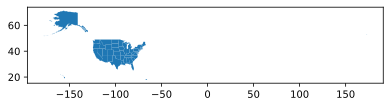

In [240]:
usstates.plot()

Why so much whitespace? This is because we are just using the default projection in the data. Some of the commonly used projections you will need to know for this lecture are:
- `ESRI:102003` USA Contiguous [Albers Equal Area Conic](https://en.wikipedia.org/wiki/Albers_projection): "official standard projection" in the US
- `EPSG:4326` or [Plate Carree](https://en.wikipedia.org/wiki/Equirectangular_projection): latitude/longitude coordinate system based on the Earth's center of mass
- `EPSG:3857` or [Mercator](https://en.wikipedia.org/wiki/Mercator_projection): used by most web maps (Google Maps, OpenStreetMap, etc.)

![Example of US map projections](us_projections.jpeg)

Let's convert our GeoDataFrame's projection to the one we are most used to seeing the US in.

<Axes: >

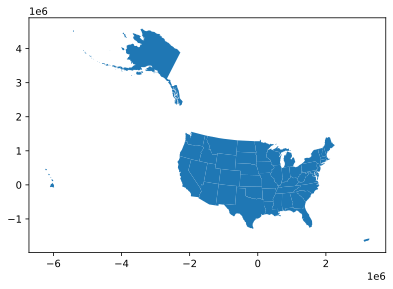

In [241]:
usstates = usstates.to_crs('ESRI:102003')
usstates.plot()

HI, AL, PR are obviously kind of out of the way. It's actually a bit non-trivial to move them in GeoPandas, so let's drop them for now.

<Axes: >

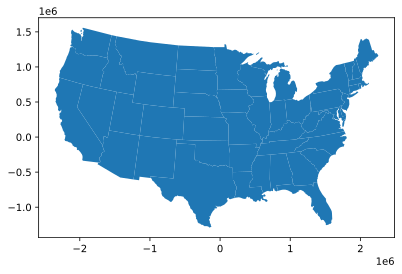

In [242]:
lower48 = usstates[~usstates['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

lower48.plot()

## Adding markers on top of a data map

Now that we have the base map, we can draw marks on top of maps, in this case the size of the [50 largest cities](https://www.dataviscourse.net/tutorials/lectures/lecture-maps/us-cities.csv) in the US. 

In [251]:
largest_cities = gpd.read_file('./us-cities.csv', x_possible_names='lng', y_possible_names='lat')

largest_cities.head()

,city,population,lat,lng,geometry
0,New York,18972871,40.6943,-73.9249,POINT (-73.92490 40.69430)
1,Los Angeles,12121244,34.1141,-118.4068,POINT (-118.40680 34.11410)
2,Chicago,8595181,41.8375,-87.6866,POINT (-87.68660 41.83750)
3,Miami,5711945,25.7840,-80.2101,POINT (-80.21010 25.78400)
4,Dallas,5668165,32.7935,-96.7667,POINT (-96.76670 32.79350)


Lat & lon values are standard here, but you need to tell GeoPandas what "projection" to use still. Here, it's just EPSG 4326 which is the lat/lon coordinate system.

<Axes: >

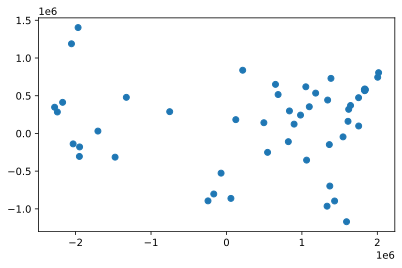

In [252]:
# Need to know what projection your data is in
# It's in latitude/longitude coordinate system / equirectangular

largest_cities.crs = "EPSG:4326"

largest_cities = largest_cities.to_crs('ESRI:102003')

largest_cities.plot()

Points don't tell us much by themselves, let's overlay onto states

<Axes: >

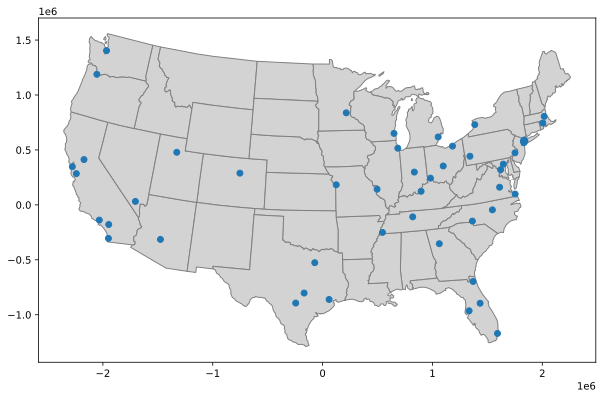

In [258]:
fig, ax = plt.subplots(figsize=(10, 10))

lower48.plot(ax=ax, color='lightgray', edgecolor="gray")
largest_cities.plot(ax=ax)


We can play around will colors / fills / transparencies.

We can also add another dimension and scale the point size by city population

In [260]:
largest_cities['population'] = pd.to_numeric(largest_cities['population'])

largest_cities['population']

0     18972871
1     12121244
2      8595181
3      5711945
4      5668165
5      5650910
6      5512873
7      5046555
8      4810669
9      4208580
10     4047095
11     3522856
12     3438221
13     3290197
14     3084174
15     2856952
16     2736074
17     2683956
18     2650725
19     2405464
20     2205092
21     2150373
22     2092481
23     2036875
24     2022285
25     1927699
26     1924167
27     1910785
28     1729879
29     1720279
30     1712287
31     1694263
32     1683059
33     1659305
34     1659251
35     1644497
36     1556848
37     1516107
38     1500764
39     1472654
40     1340981
41     1270149
42     1220191
43     1135344
44     1098486
45     1062018
46     1034498
47     1022630
48     1008069
49     1004655
Name: population, dtype: int64

<Axes: >

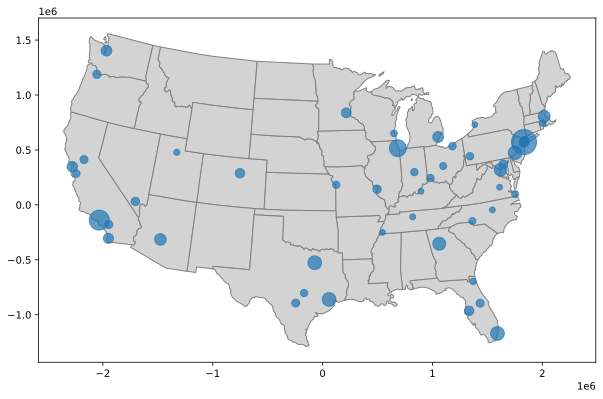

In [264]:
fig, ax = plt.subplots(figsize=(10, 10))

lower48.plot(ax=ax, color='lightgray', edgecolor="gray")
largest_cities.plot(ax=ax, markersize=largest_cities['population'] / 30000, alpha=0.7)

## Adding Data as a Choropleth

Another way to add values to a map is choropleths. Here is an example for a choropleth map, coloring [each state by its agricultural output](https://www.dataviscourse.net/tutorials/lectures/lecture-maps/us-ag-productivity-2004.csv).

In [265]:
agriculture_df = pd.read_csv('./us-ag-productivity-2004.csv')
agriculture_df.head()

,state,value
0,Alabama,1.1791
1,Arkansas,1.3705
2,Arizona,1.3847
3,California,1.7979
4,Colorado,1.0325


The trick here is to join the data about the ouptut to the geography information, just like a regular Pandas DataFrame:

In [267]:
lower48 = lower48.merge(
    agriculture_df, 
    how="left",
    left_on="name",
    right_on='state'
)

lower48.head()

,id,name,geometry,state,value
0,01,Alabama,"POLYGON ((781042.892 -244321.512, 939086.325 -...",Alabama,1.1791
1,04,Arizona,"POLYGON ((-1146224.363 22777.743, -1233398.244...",Arizona,1.3847
2,05,Arkansas,"POLYGON ((135437.391 -110751.580, 518660.061 -...",Arkansas,1.3705
3,06,California,"POLYGON ((-2209644.717 823606.755, -2141972.30...",California,1.7979
4,08,Colorado,"POLYGON ((-991968.743 454933.381, -810423.111 ...",Colorado,1.0325


What kind of color scale would work best here?

<Axes: >

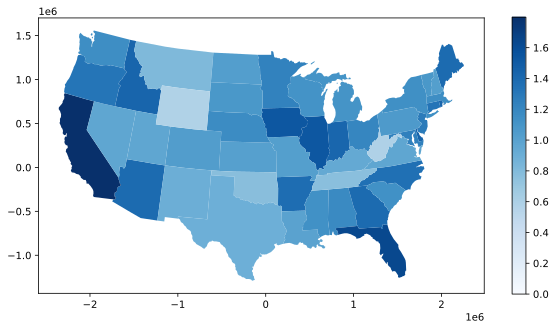

In [274]:
fig, ax = plt.subplots(figsize=(10, 10))

lower48.plot(ax=ax, column='value', legend=True, legend_kwds={'shrink': 0.5}, cmap='Blues', vmin=0)


___

# Street Maps / Contextily

Contextily is a Python library that gives a way to add **static** street maps to shapefiles

In [195]:
import contextily as cx

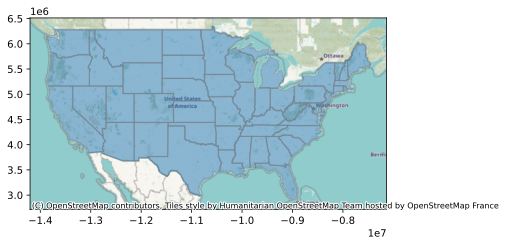

In [278]:
# Change our projection to Mercator to match web maps

lower48 = lower48.to_crs('EPSG:3857')

plot = lower48.plot(alpha=0.5, edgecolor='gray')

cx.add_basemap(plot)


It's important to make sure we match projections. Streetmaps typically come in EPSG 3857 which is used by Google Maps, OpenStreetMap, etc.

Alternatively, we could force Contextily to give us the street map in Albers ESRI:102003 that we "prefer" for US states maps

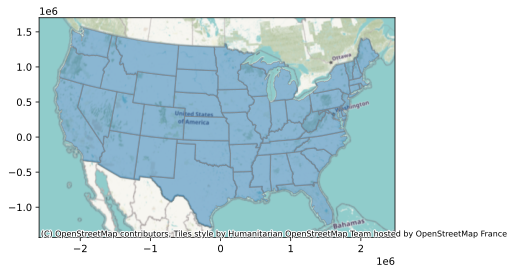

In [281]:
lower48 = lower48.to_crs('ESRI:102003')

plot = lower48.plot(alpha=0.5, edgecolor='gray')

cx.add_basemap(plot, crs=lower48.crs)

## UFO Sightings

We can also overlay location points with street maps

In [282]:
# Read file
ufo_sightings = gpd.read_file('ufo-data.csv', x_possible_names='longitude', y_possible_names='latitude')

# Filter out one wrong data point

ufo_sightings.head()


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,geometry
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,POINT (-97.94111 29.88306)
1,10/10/1949 21:00,lackland afb,tx,,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,POINT (-98.58108 29.38421)
2,10/10/1955 17:00,chester (uk/england),,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,POINT (-2.91667 53.20000)
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,POINT (-96.64583 28.97833)
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,POINT (-157.80361 21.41806)


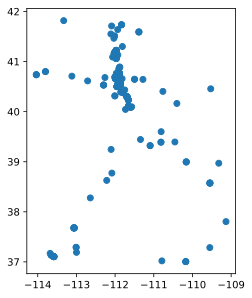

In [287]:
ufo_sightings.head()

# Set projection

ufo_sightings.crs = "EPSG:4326"

# Filter to first 200 Utah data points

ufo_sightings = ufo_sightings[ufo_sightings['state'] == 'ut'][0:200]

# Remove one outlier where latitude is zero

ufo_sightings = ufo_sightings[ufo_sightings['latitude'] != 0]

plot = ufo_sightings.plot()


We can do so by "summoning" a basemap onto a map of points (above), or

By plotting points over a map of a place. The cx.Place function can look up a map of a named place.

In [165]:
# The other way around
fig, ax = plt.subplots(figsize=(10, 10))

ufo_sightings.plot(ax=ax)
cx.add_basemap(ax=ax, crs=ufo_sightings.crs)

# Interactivity / Folium

You can also use the Folium library to create interactive streetmaps.

GeoPandas has an .explore() method that overlays anything we've talked about before onto a Folium interactive streetmap.

In [ ]:
ufo_df.explore()

You can also play with Folium directly and just query up a map based on coordinates.

Using the `zoom_start` parameter, you can specify the zoom level you want to begin with. Here's a helpful conversion table of what the numerical values mean:
| Zoom Level | Level of Detail| 
| ----------- | ----------- |
|1	| World |
|5	| Landmass/Continent |
|10	| City |
|15	| Streets | 
|20	| Buildings |

In [167]:
import folium

In [ ]:
folium.Map(location=[40.7608, -111.8910], zoom_start=15, width = 500, height = 500)